In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import deeptime.markov as markov
from deeptime.plots import plot_implied_timescales
from deeptime.plots import plot_ck_test
from deeptime.util.validation import implied_timescales
import pyemma
import networkx as nx

import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.util
import hpa.msm
import hpa.plots
plt.style.use('/localscratch/zippoema/md_plots/corr_plot.mplstyle')

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
path = '/localscratch/zippoema/project_ness/simulations/ness_1-ck1d_1-pp3/sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/'
path_simple = '/localscratch/zippoema/project_ness/simulations/simple-ness_CAL3/'
path_an = '/localscratch/zippoema/project_ness/analysis/sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/'
path_simple_an = '/localscratch/zippoema/project_ness/analysis/simple-ness_CAL3/'
path_old = '/media/zippoema/Elements/zippo_phd_data/project_hps_phospho_tdp43_natcomm/simple-ness/simulations/'


In [3]:
def ck_test(states, lagtimes, reversible=False):

    counts = markov.TransitionCountEstimator(lagtime=1, count_mode='effective').fit_fetch(states-1)
    msm1 = markov.msm.BayesianMSM(n_samples=100, n_steps=20, reversible=reversible).fit_fetch(counts)
    tr_mat = msm1.gather_stats('transition_matrix').mean
    predicted_t = []
    estimated_t = []
    estimated_t_err = []
    
    for lagtime in lagtimes:
        counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
        msm_tmp = markov.msm.BayesianMSM(n_samples=100, n_steps=20, reversible=reversible).fit_fetch(counts)
        tr_mat_tmp = msm_tmp.gather_stats('transition_matrix').mean
        err_tr_mat_tmp = msm_tmp.gather_stats('transition_matrix').std
        estimated_t.append(tr_mat_tmp)
        estimated_t_err.append(err_tr_mat_tmp)
        predicted_t.append(np.linalg.matrix_power(tr_mat,lagtime))
    
    return np.array(predicted_t), np.array(estimated_t), np.array(estimated_t_err)
    

# Create MSM discrete trajectory

In [9]:
# Select NESS simulation

for s in range(1,6):
    c = np.loadtxt(path_simple+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_contacts.txt')
    phospho_bool = hpa.msm.changes_to_phosphostate(c[(c[:, 2] != 0) & (c[:, 2] != 2)], step=50000, end_time=1000000000, 
                                                   save=path_simple_an+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_phosphotraj.txt')

## Bound from dist

### old HPS ser10 trajectory 4 states

In [3]:
d_old = np.loadtxt(path_old+f'sim_ser10/sim-ser10_mu-5_ck1d-rigid_tdp43_dist.txt')
d_old.shape


(195000, 154)

In [4]:
bound_bool_old = hpa.msm.boundtraj_with_dist_criterion(d_old, min_dist=3., max_dist=8, therm=0, end_time=None, save=None)
phospho_traj_old = np.loadtxt(path_old+f'sim_ser10/sim-ser10_mu-5_ck1d-rigid_tdp43_phosphotraj.txt').astype(bool)
phospho_traj_old.shape

(195000,)

In [5]:
states_old = hpa.msm.create_states_trajectory(bound_bool_old, phospho_traj_old, save=None)

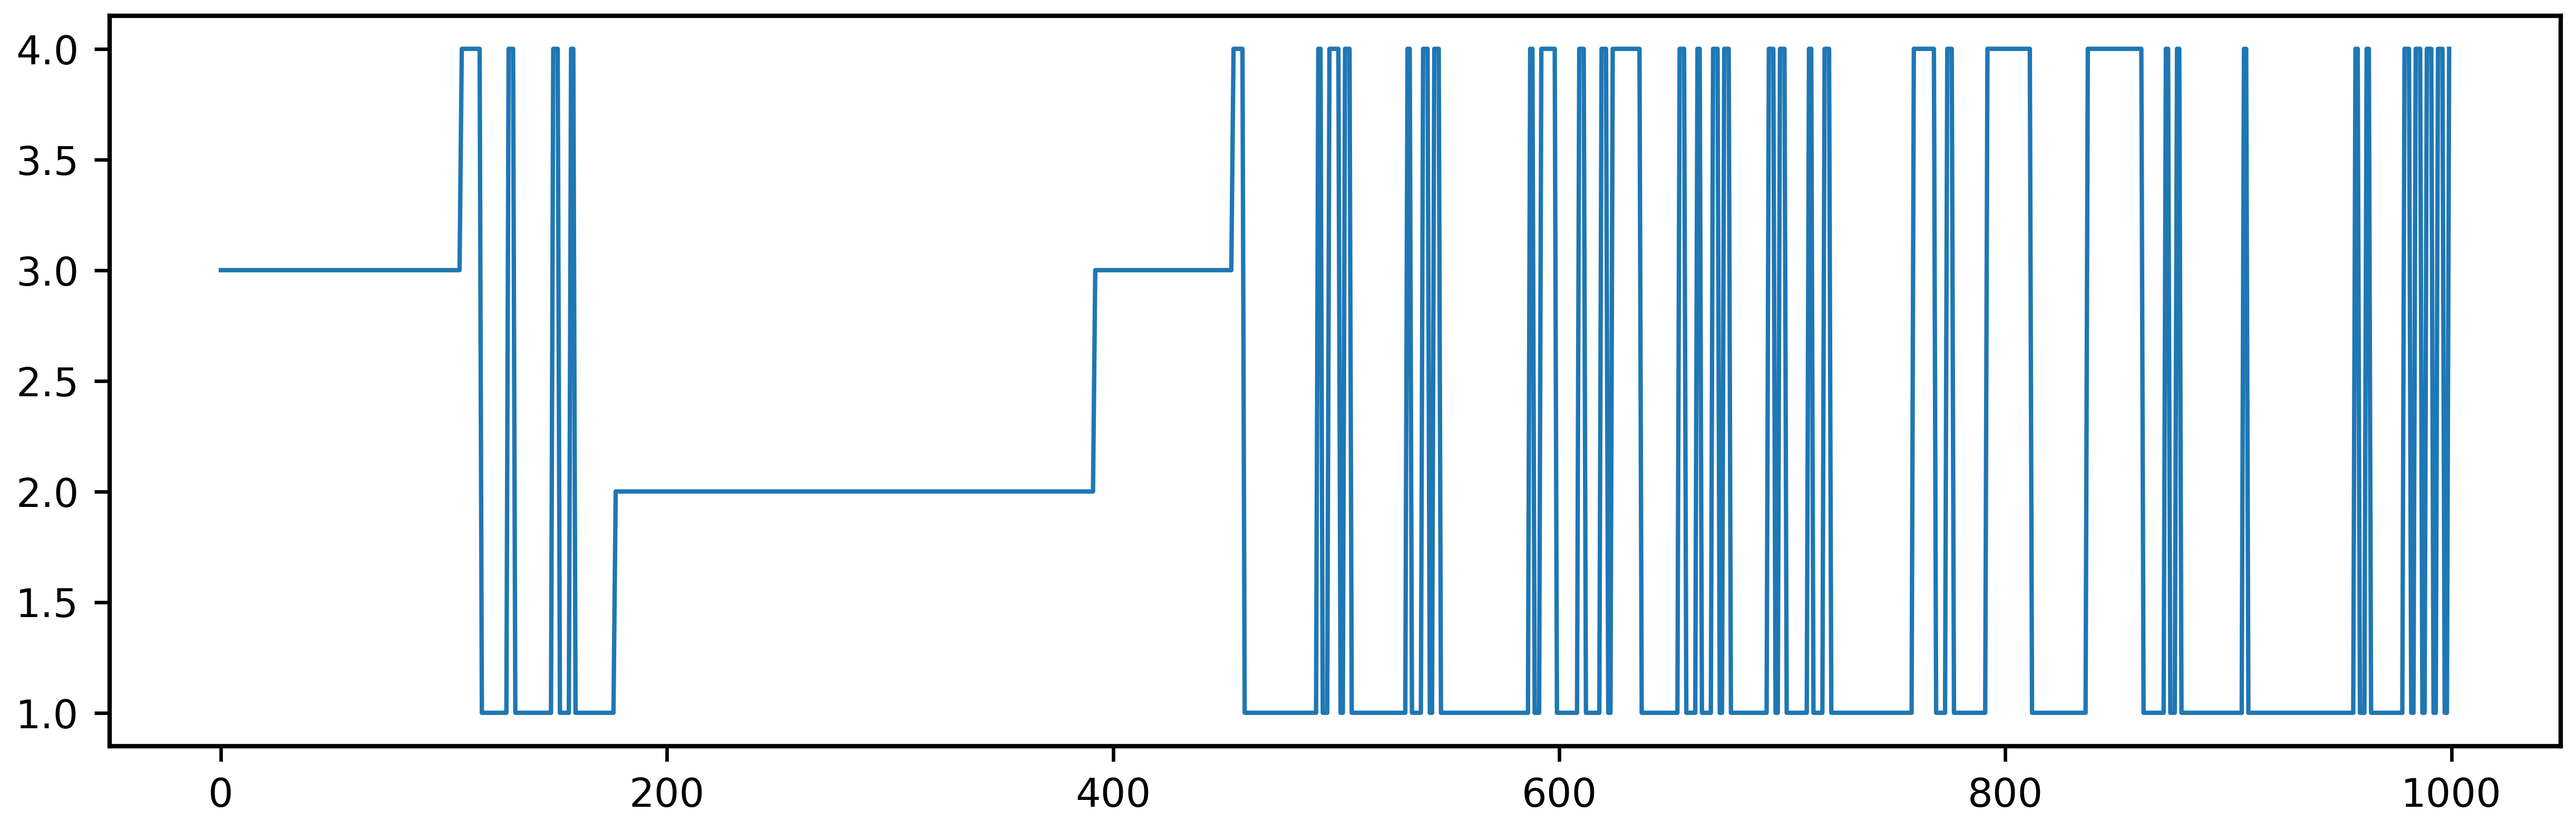

In [6]:
plt.figure(figsize=(10,3))
plt.plot(states_old[:1000], color='tab:blue')


(1.0, 35.0)

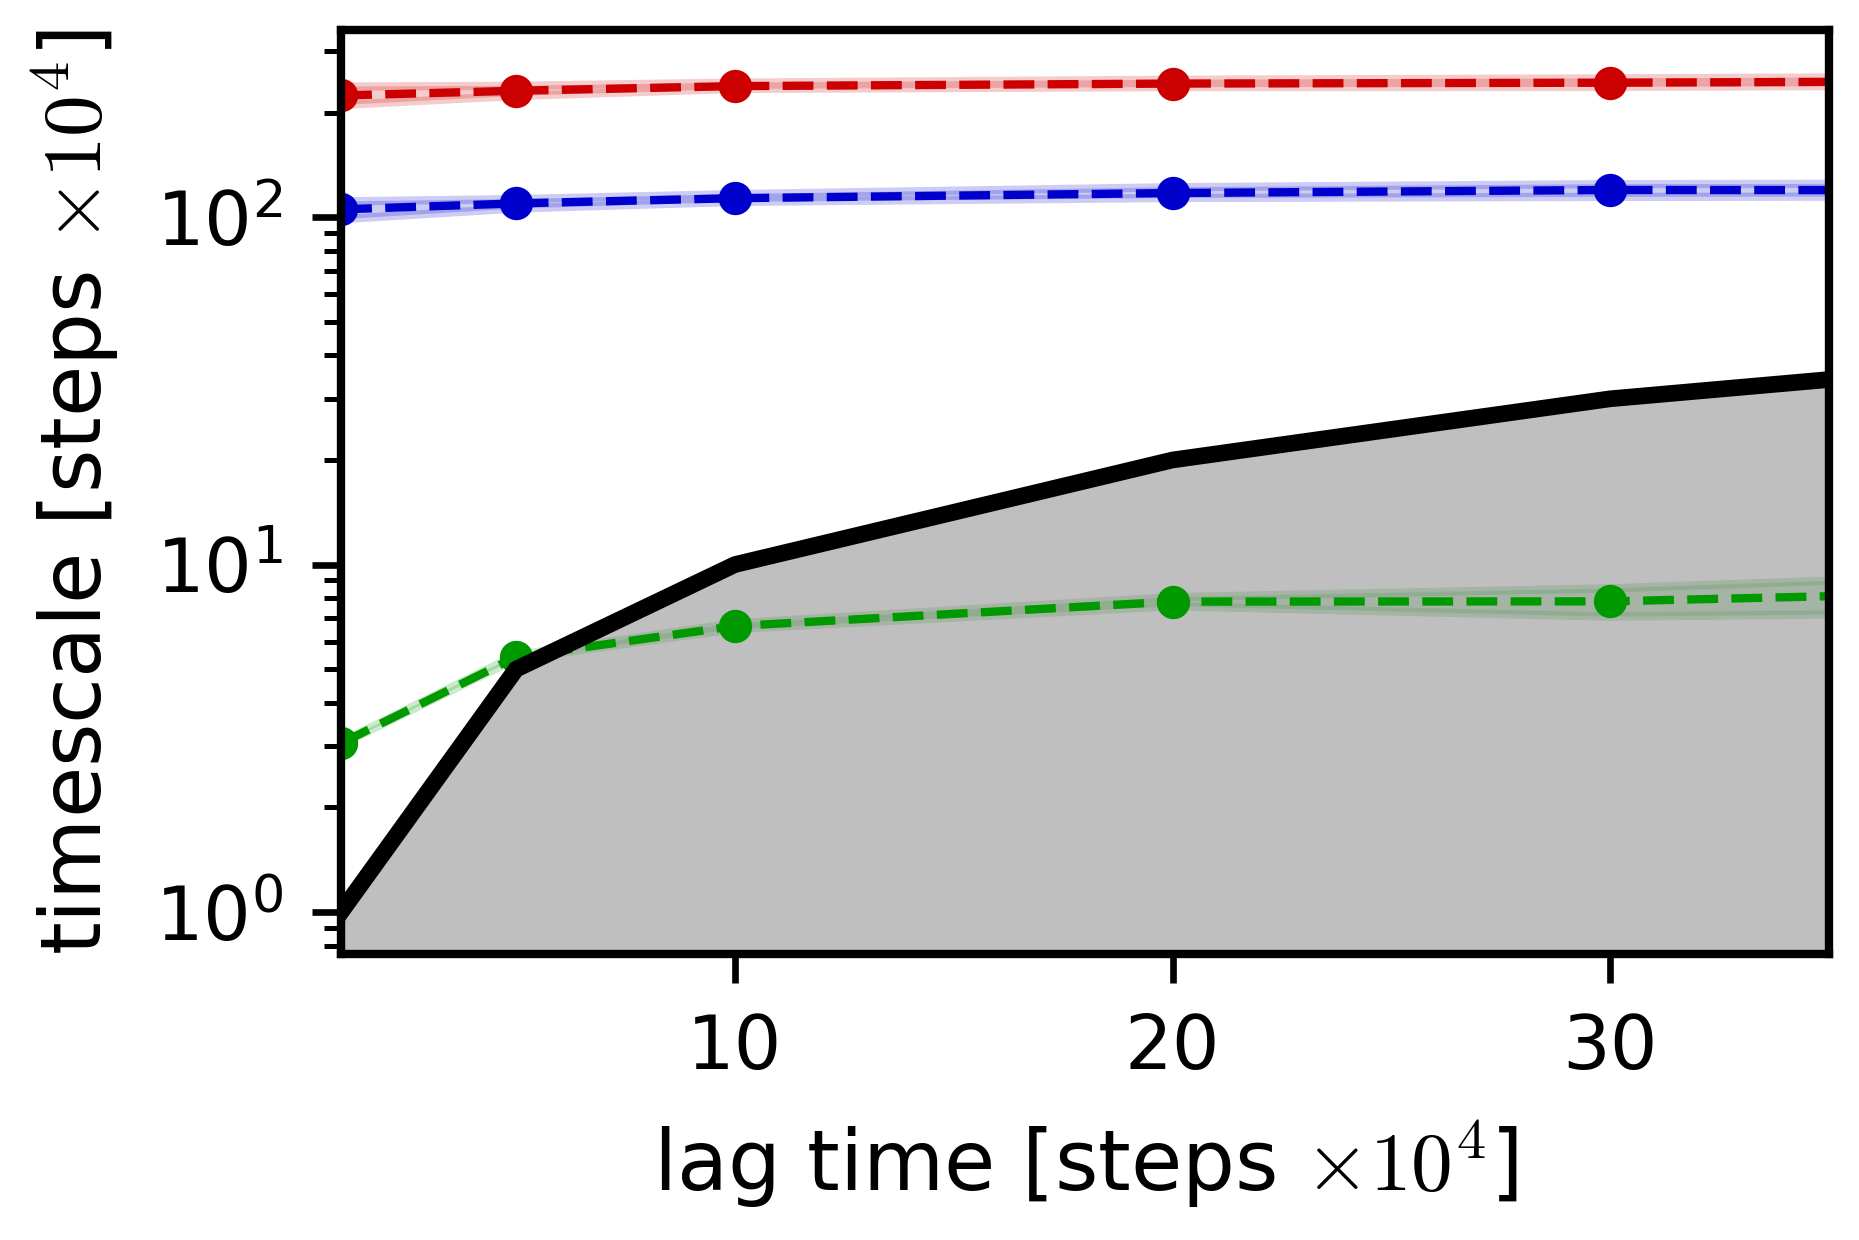

In [41]:
models = []
lagtimes = [1,5,10,20,30,50,70]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states_old-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=20, reversible=False).fit_fetch(counts))

its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(1,35)


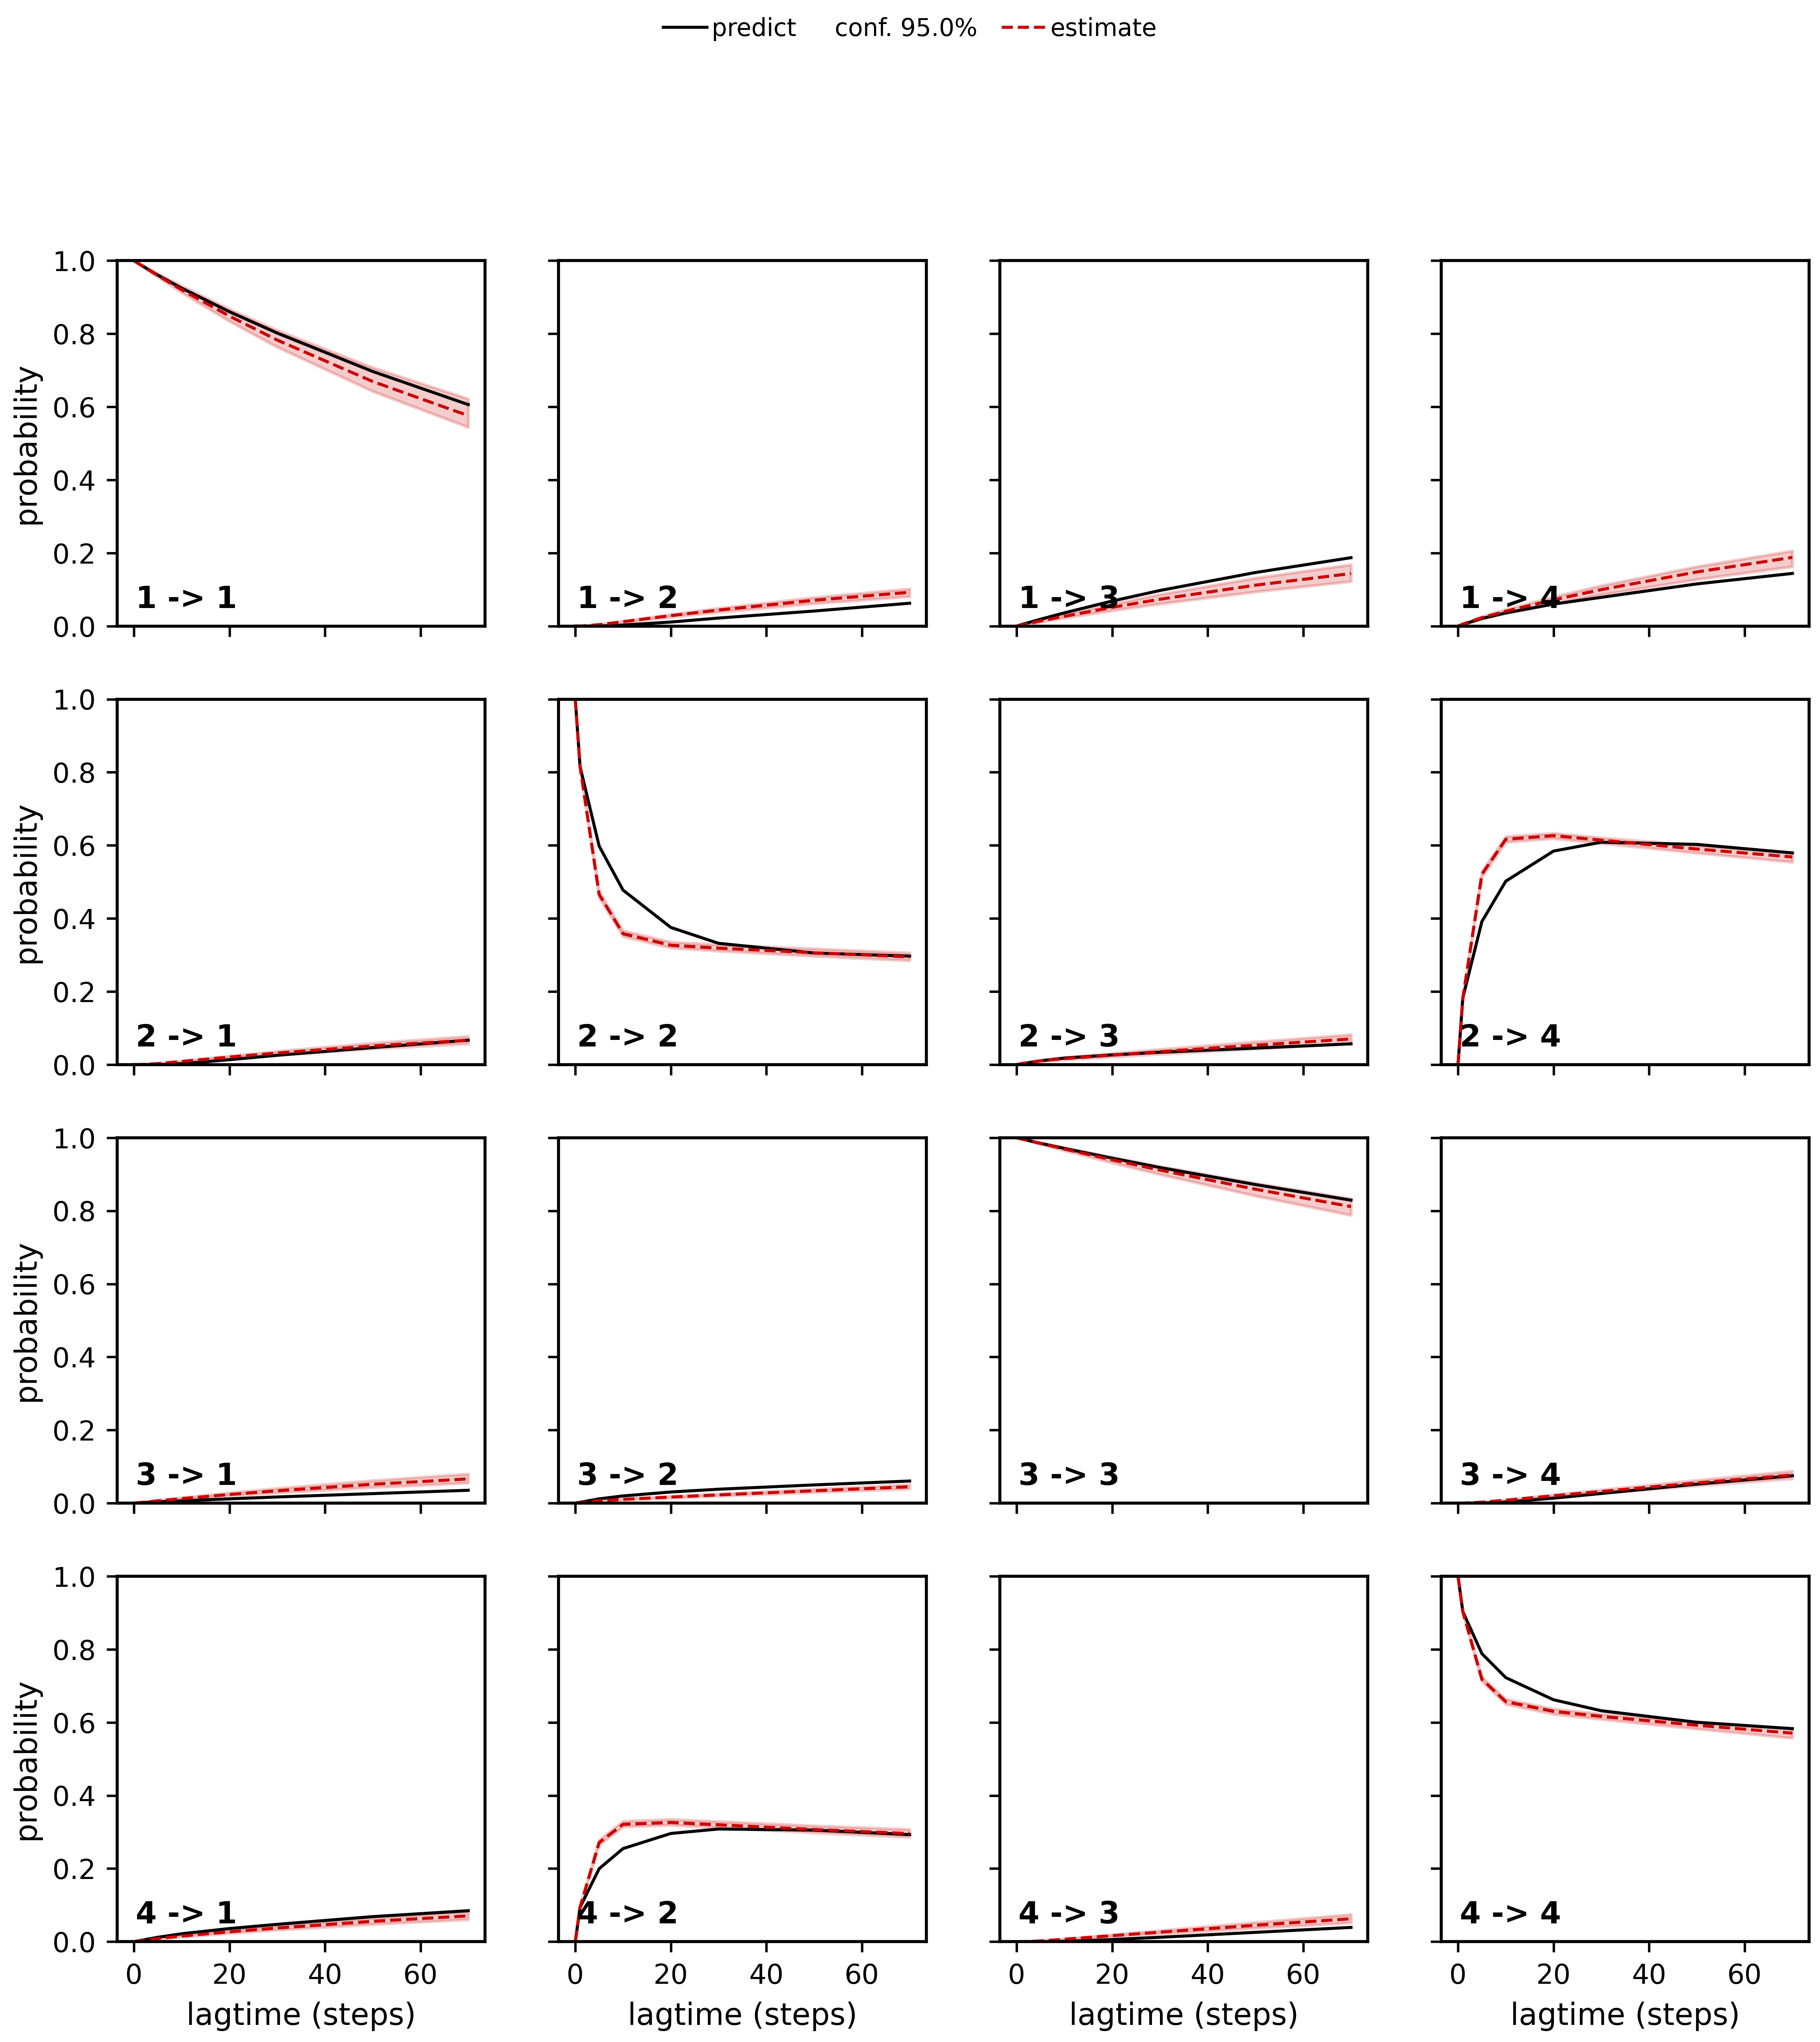

In [42]:
# model with lagtime 10
counts = markov.TransitionCountEstimator(lagtime=1, count_mode='effective').fit_fetch(states_old-1)
msm = markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts)
ck = msm.ck_test(models, 4)
plot_ck_test(ck)


In [46]:
pred_ck, est_ck, est_err_ck = ck_test(states_old, lagtimes, reversible=True)

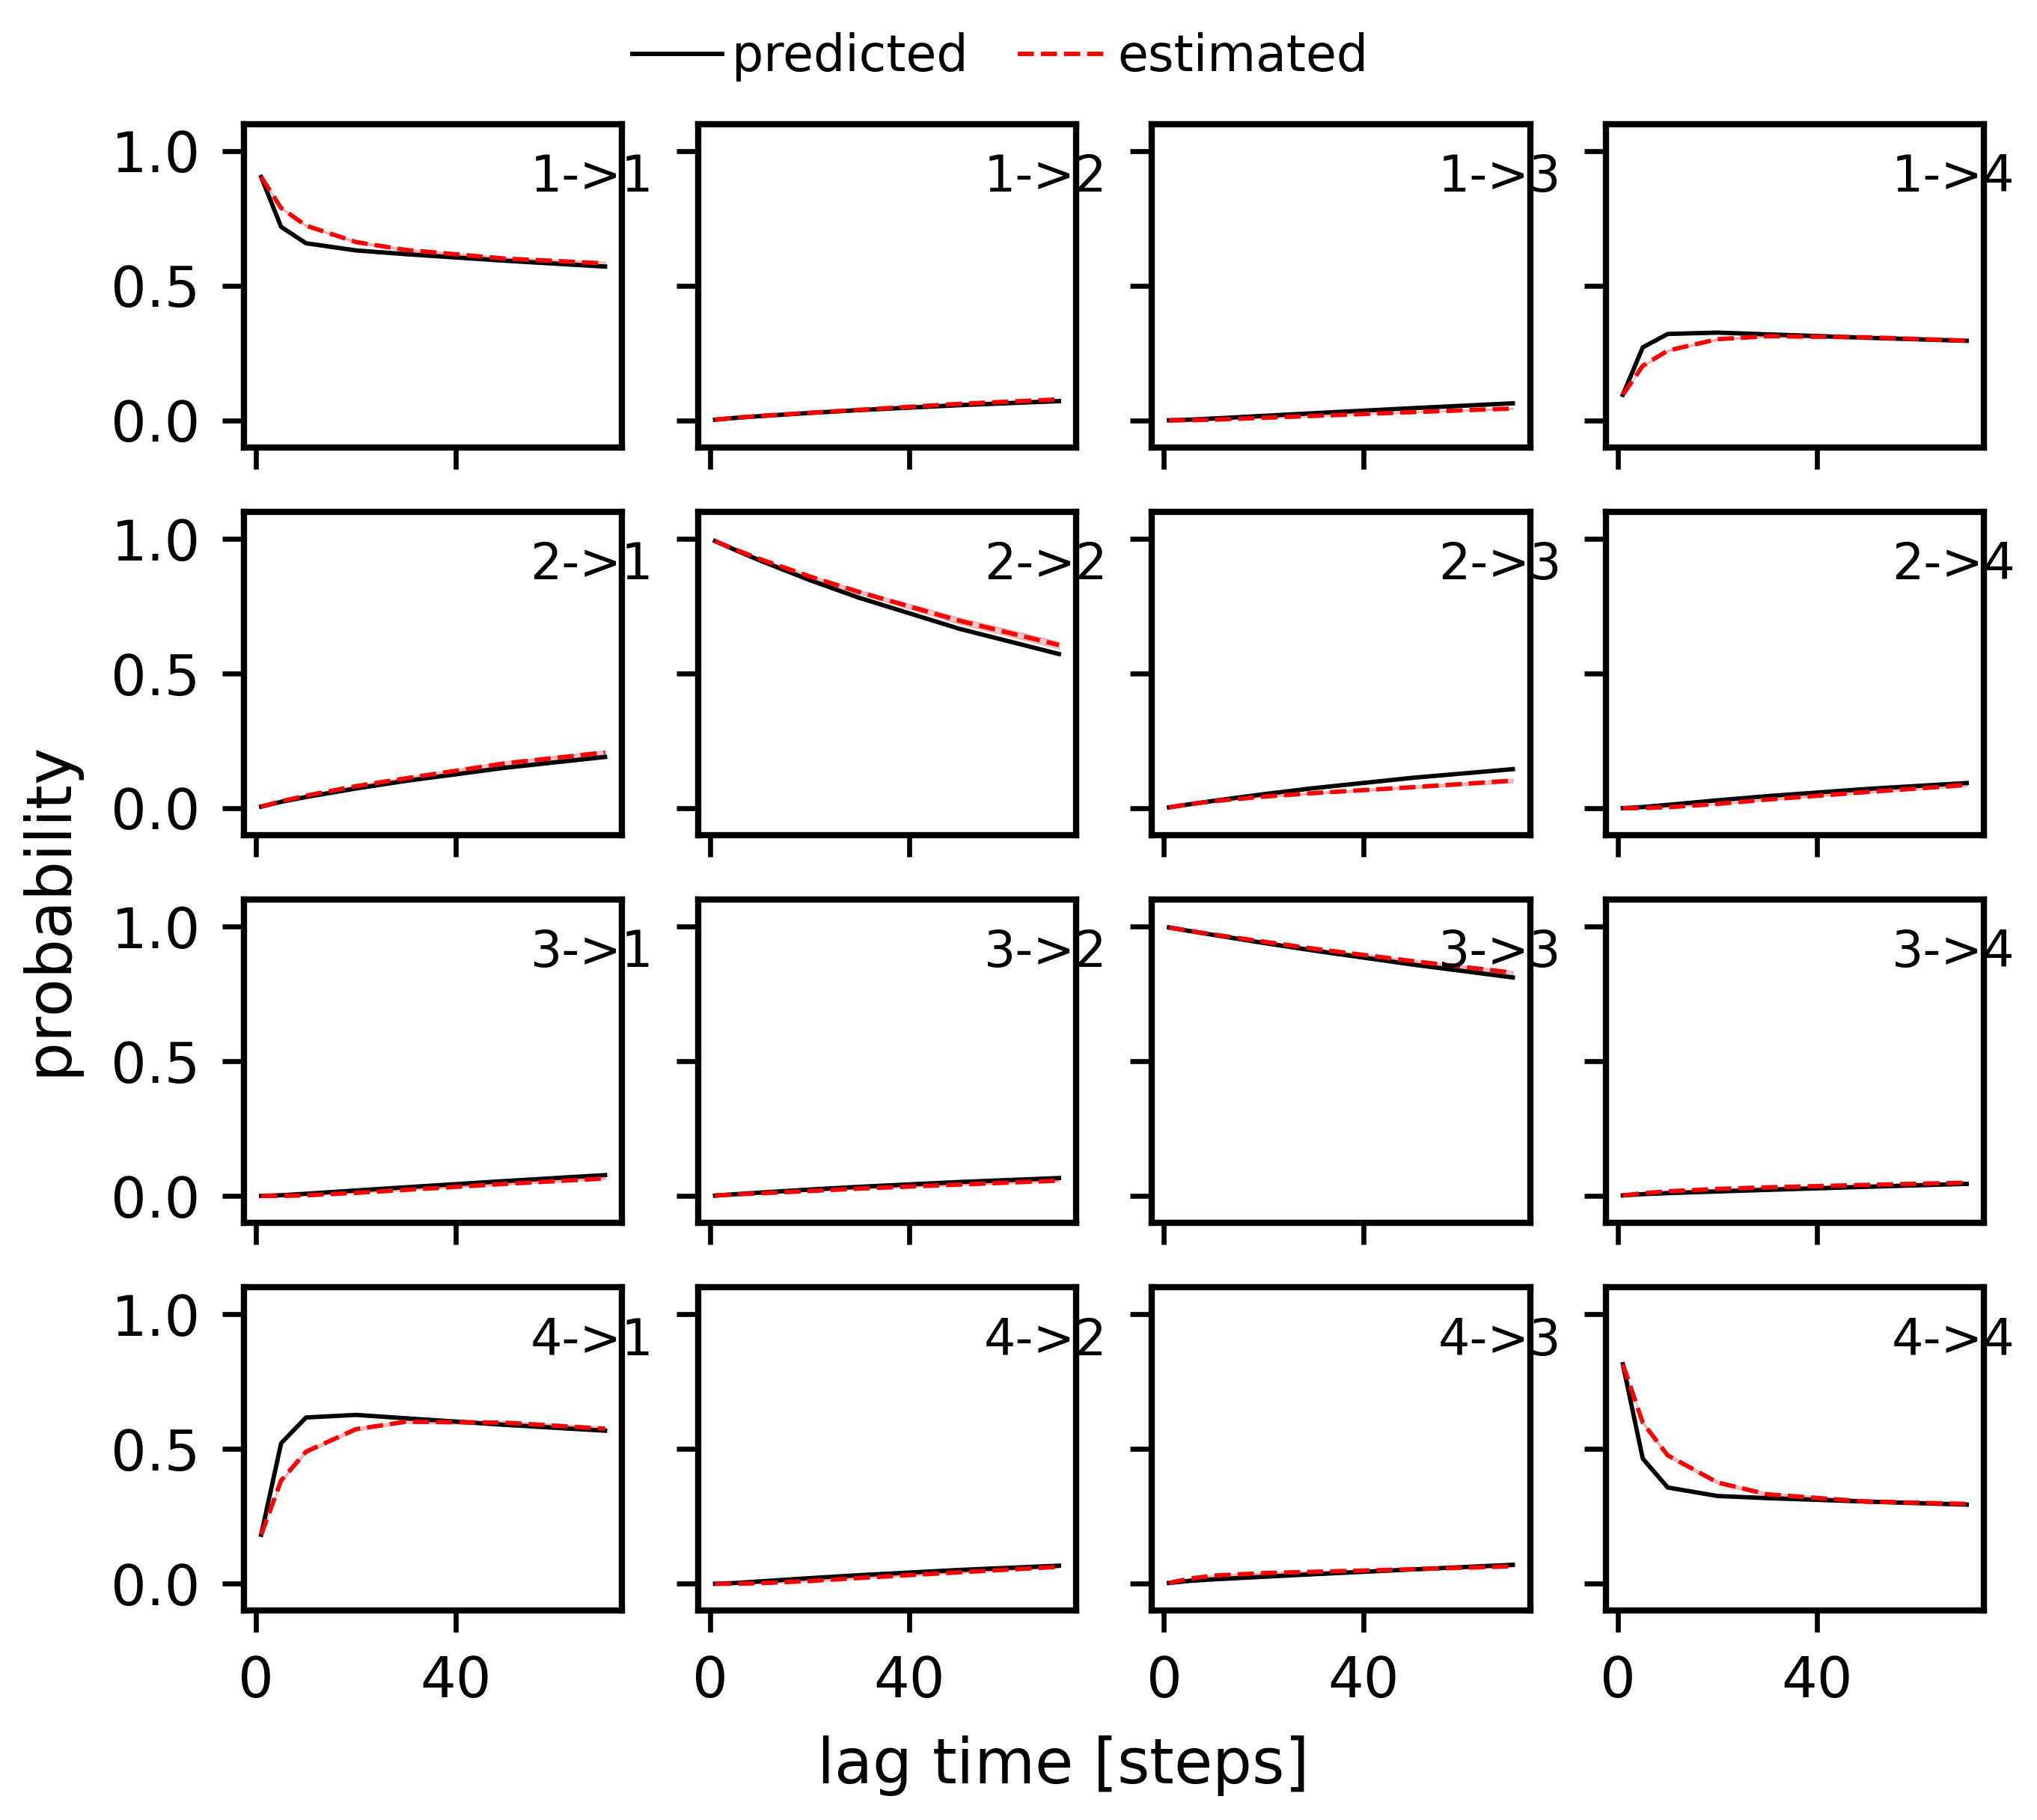

In [47]:
fig, ax = plt.subplots(4,4, figsize=(5,), sharex=True, sharey=True)
type(ax)

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,40,80],[0,40,80])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(4):
    for j in range(4):
        ax[i,j].plot(lagtimes, pred_ck[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(lagtimes, est_ck[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(lagtimes, est_ck[:,i,j]-est_err_ck[:,i,j], est_ck[:,i,j]+est_err_ck[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(55,0.85, f'{i+1}->{j+1}', fontsize=8)

        if i==3 and j==1:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==2 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(1.,3.5), ncols=2)


In [23]:
dmu_old = hpa.msm.dmu_estimate(states_old, lag=10, n_term=1000)
sigma_dmu_old = hpa.msm.bootstrap_dmu_estimate(states_old, lag=10, pow_bin=10, n_resample=30, n_term=1000)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8032.45it/s]


In [24]:
dmu_old, sigma_dmu_old

(4.993486851608588, 0.49062935317495987)

### CALVADOS3 8 states

In [174]:
s=10

In [10]:
d = np.loadtxt(path+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_dist.txt')
d.shape

(20000, 154)

In [11]:
bound_bool_ck1d = hpa.msm.boundtraj_with_dist_criterion(d[:,:154], min_dist=3., max_dist=8, therm=0, end_time=None)
bound_bool_pp3 = hpa.msm.boundtraj_with_dist_criterion(d[:,154:], min_dist=3., max_dist=8, therm=0, end_time=None)

np.savetxt(path_an+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_distboundtraj_ck1d.txt', bound_bool_ck1d)
np.savetxt(path_an+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_distboundtraj_pp3.txt', bound_bool_pp3)

In [12]:
phospho_bool = np.loadtxt(path_an+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_phosphotraj.txt').astype(bool)

In [13]:
bound_bool_ck1d.shape

(20000,)

In [179]:
states_ck1d = hpa.msm.create_states_trajectory(bound_bool_ck1d, phospho_bool, save=None)
states_pp3 = hpa.msm.create_states_trajectory(bound_bool_pp3, phospho_bool, save=None)
states = np.column_stack((states_ck1d,states_pp3))

In [180]:
states_num = hpa.msm.create_states_trajectory_2enzymes(bound_bool_ck1d,bound_bool_pp3,phospho_bool, 
                                                       save=path_an+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_states.txt')

In [181]:
print([ (states[i], states_num[i]) for i in range(5638,5700) ])
print()
print(np.max(states_num), np.min(states_num))

[(array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 3]), 7), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([3, 4]), 6), (array([3, 4]), 6), (array([3, 4]), 6), (array([3, 4]), 6), (array([3, 4]), 6), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([3, 4]), 6), (array([3, 4]), 6), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([3, 4]), 6), (array([3, 4]), 6), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([3, 4]), 6), (array([3, 4]), 6), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5), (array([4, 4]), 5),

### CALVADOS3 6 states

### CALVADOS3 4 states

In [38]:
s=5

In [39]:
d = np.loadtxt(path_simple+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_dist.txt')
d.shape

(20000, 154)

In [40]:
bound_bool_ck1d = hpa.msm.boundtraj_with_dist_criterion(d[:,:154], min_dist=3., max_dist=8, therm=0, end_time=None)
np.savetxt(path_simple_an+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_distboundtraj.txt', bound_bool_ck1d)
bound_bool_ck1d.shape

(20000,)

In [41]:
phospho_bool = np.loadtxt(path_simple_an+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_phosphotraj.txt').astype(bool)


In [42]:
states_ck1d = hpa.msm.create_states_trajectory(bound_bool_ck1d, phospho_bool, 
                                               save=path_simple_an+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_states.txt')


# Compute rates MSM

### CALVADOS3 4 states

In [25]:
states = np.array([], dtype=int)
for s in range(1,6):
    #tmp = np.loadtxt(path_an+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_states.txt').astype(int)
    tmp = np.loadtxt(path_simple_an+f'sim_ser19_dmu-10_1-tdp43-2pser_1-ck1d-open/sim{s}_ser19_dmu-10_1-tdp43-2pser_com-ck1d-open_CAL3_states.txt').astype(int)
    states = np.append(states, tmp)

print(np.max(states), np.min(states))
states

4 1


array([1, 1, 1, ..., 3, 4, 4])

In [5]:
models = []
lagtimes = [1,2,3,5,10,20,35]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts))

### Implied timescales

(1.0, 35.0)

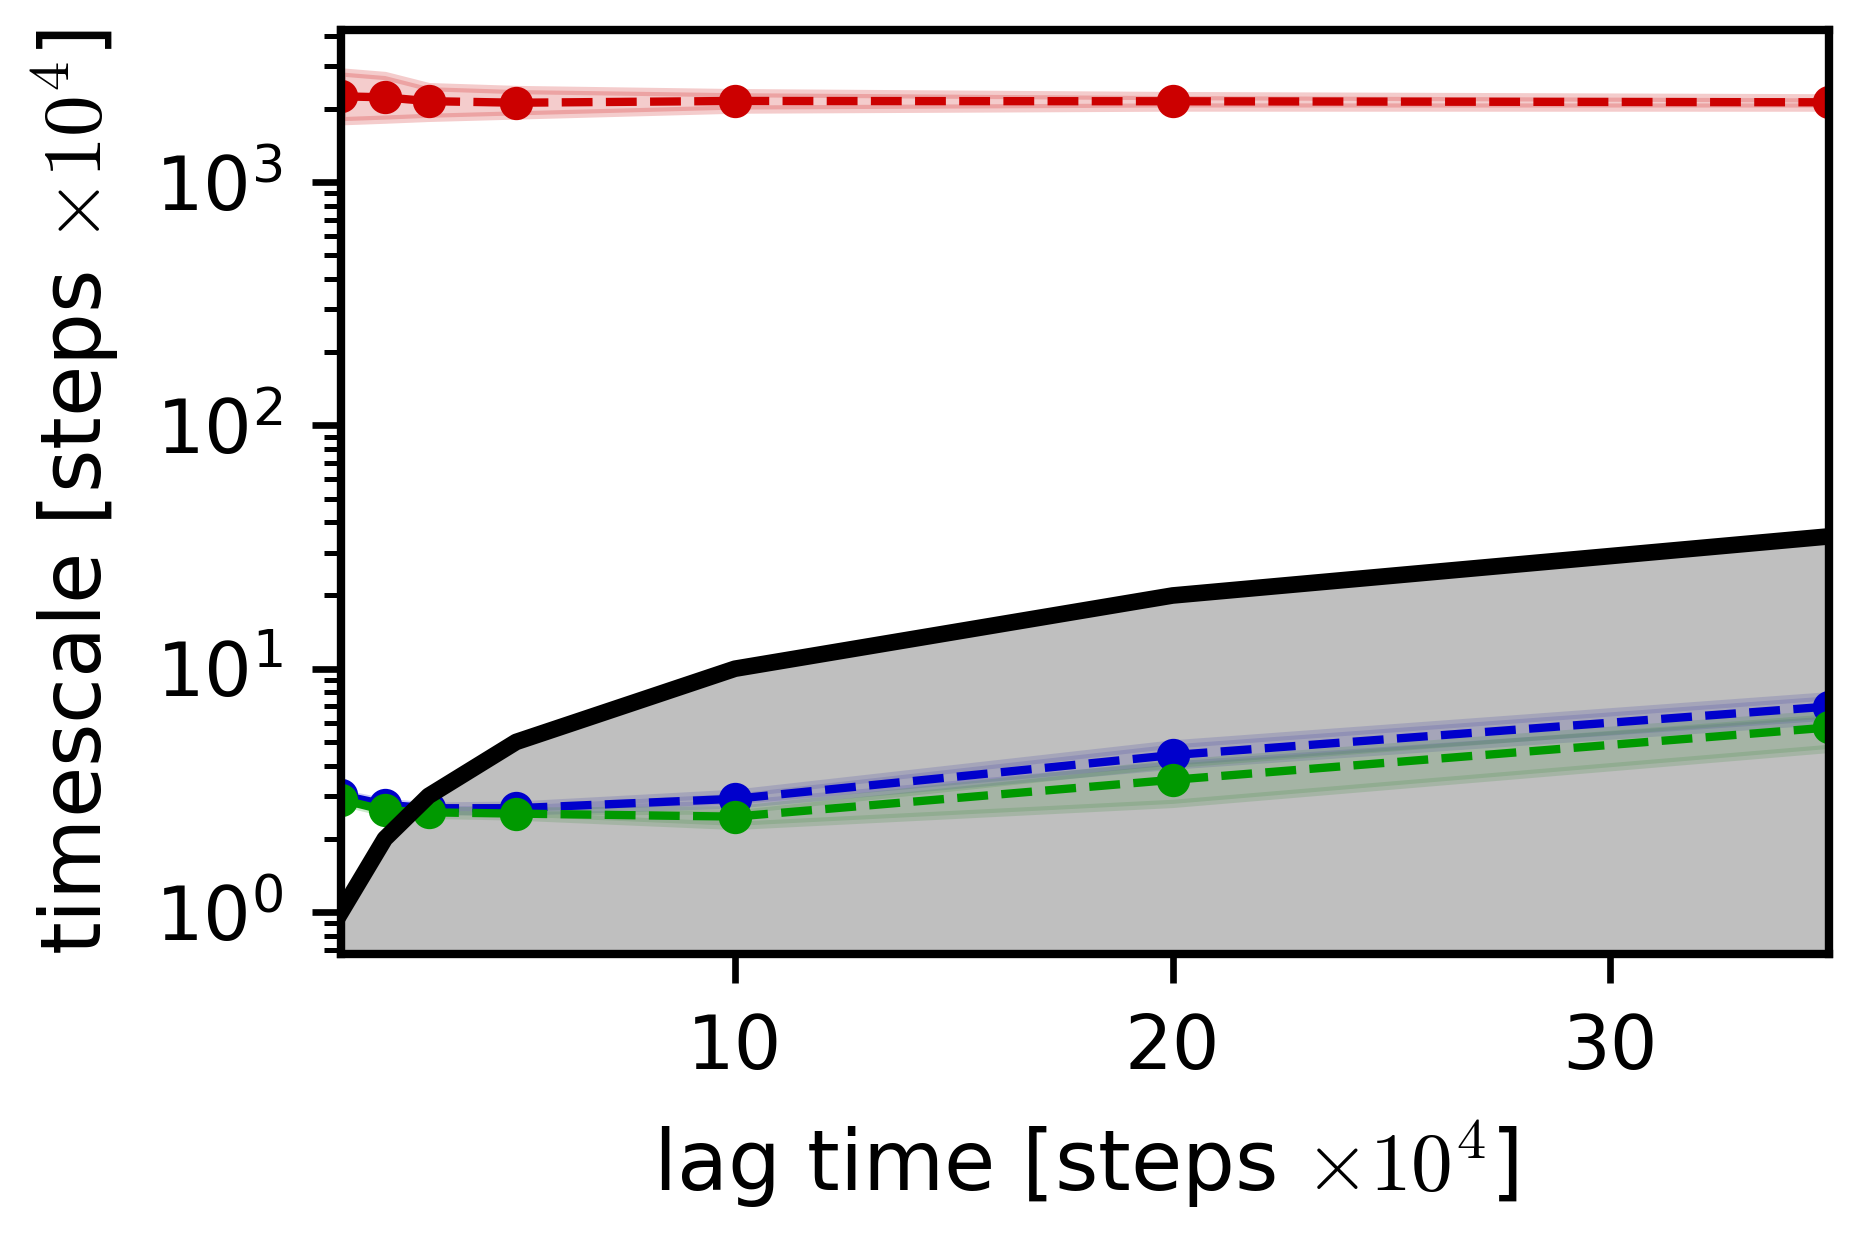

In [6]:
its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(1,35)


### Chapman-Kolmogorov test

In [7]:
# model with lagtime 10
pred_ck, est_ck, est_err_ck = ck_test(states, lagtimes, reversible=False)

In [9]:
counts = markov.TransitionCountEstimator(lagtime=3, count_mode='effective').fit_fetch(states-1)
msm = markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts)

tr_mat = msm.gather_stats('transition_matrix').mean
tr_mat

array([[8.97574106e-01, 1.01945039e-01, 3.39958551e-04, 1.40896427e-04],
       [5.72505795e-01, 4.24988236e-01, 1.90312392e-03, 6.02845082e-04],
       [1.61205574e-03, 1.59524809e-03, 4.12344517e-01, 5.84448179e-01],
       [1.13312841e-04, 8.67216211e-05, 1.01643813e-01, 8.98156152e-01]])

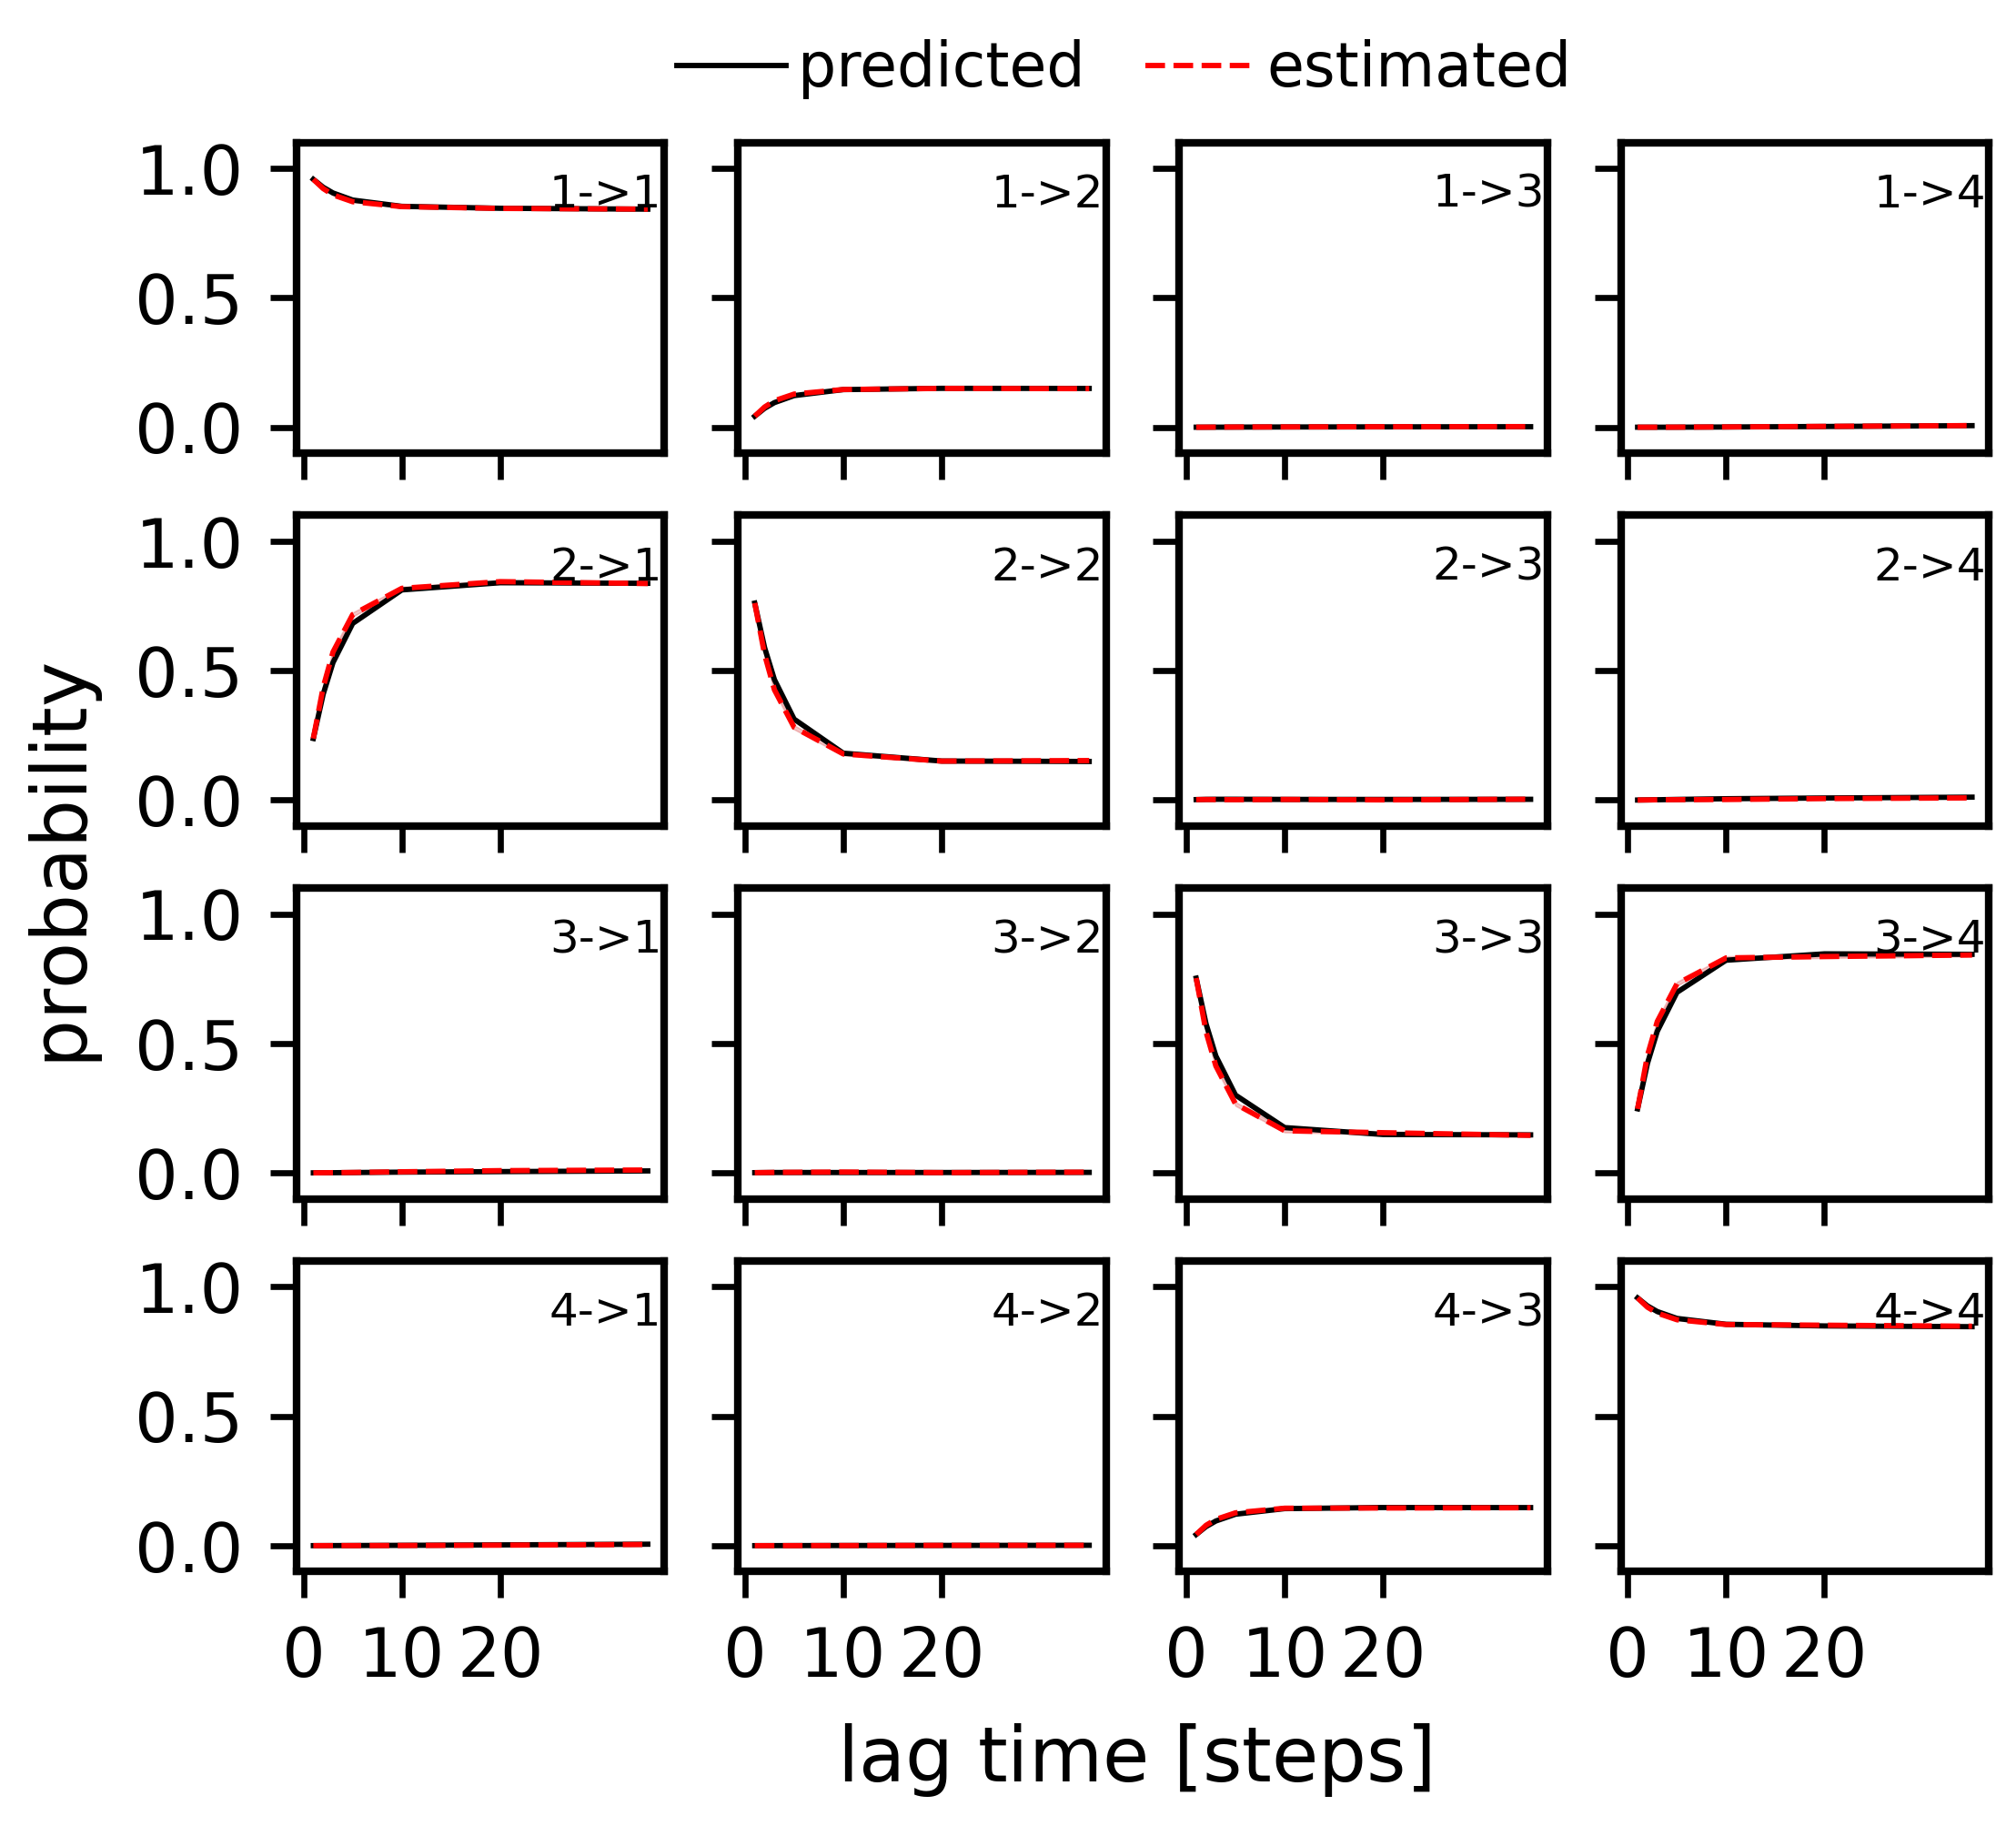

In [10]:
fig, ax = plt.subplots(4,4, figsize=(4,3.4), sharex=True, sharey=True)
type(ax)

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,10,20],[0,10,20])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(4):
    for j in range(4):
        ax[i,j].plot(lagtimes, pred_ck[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(lagtimes, est_ck[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(lagtimes, est_ck[:,i,j]-est_err_ck[:,i,j], est_ck[:,i,j]+est_err_ck[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(25,0.85, f'{i+1}->{j+1}', fontsize=6)

        if i==3 and j==1:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==2 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(1.,3.5), ncols=2)

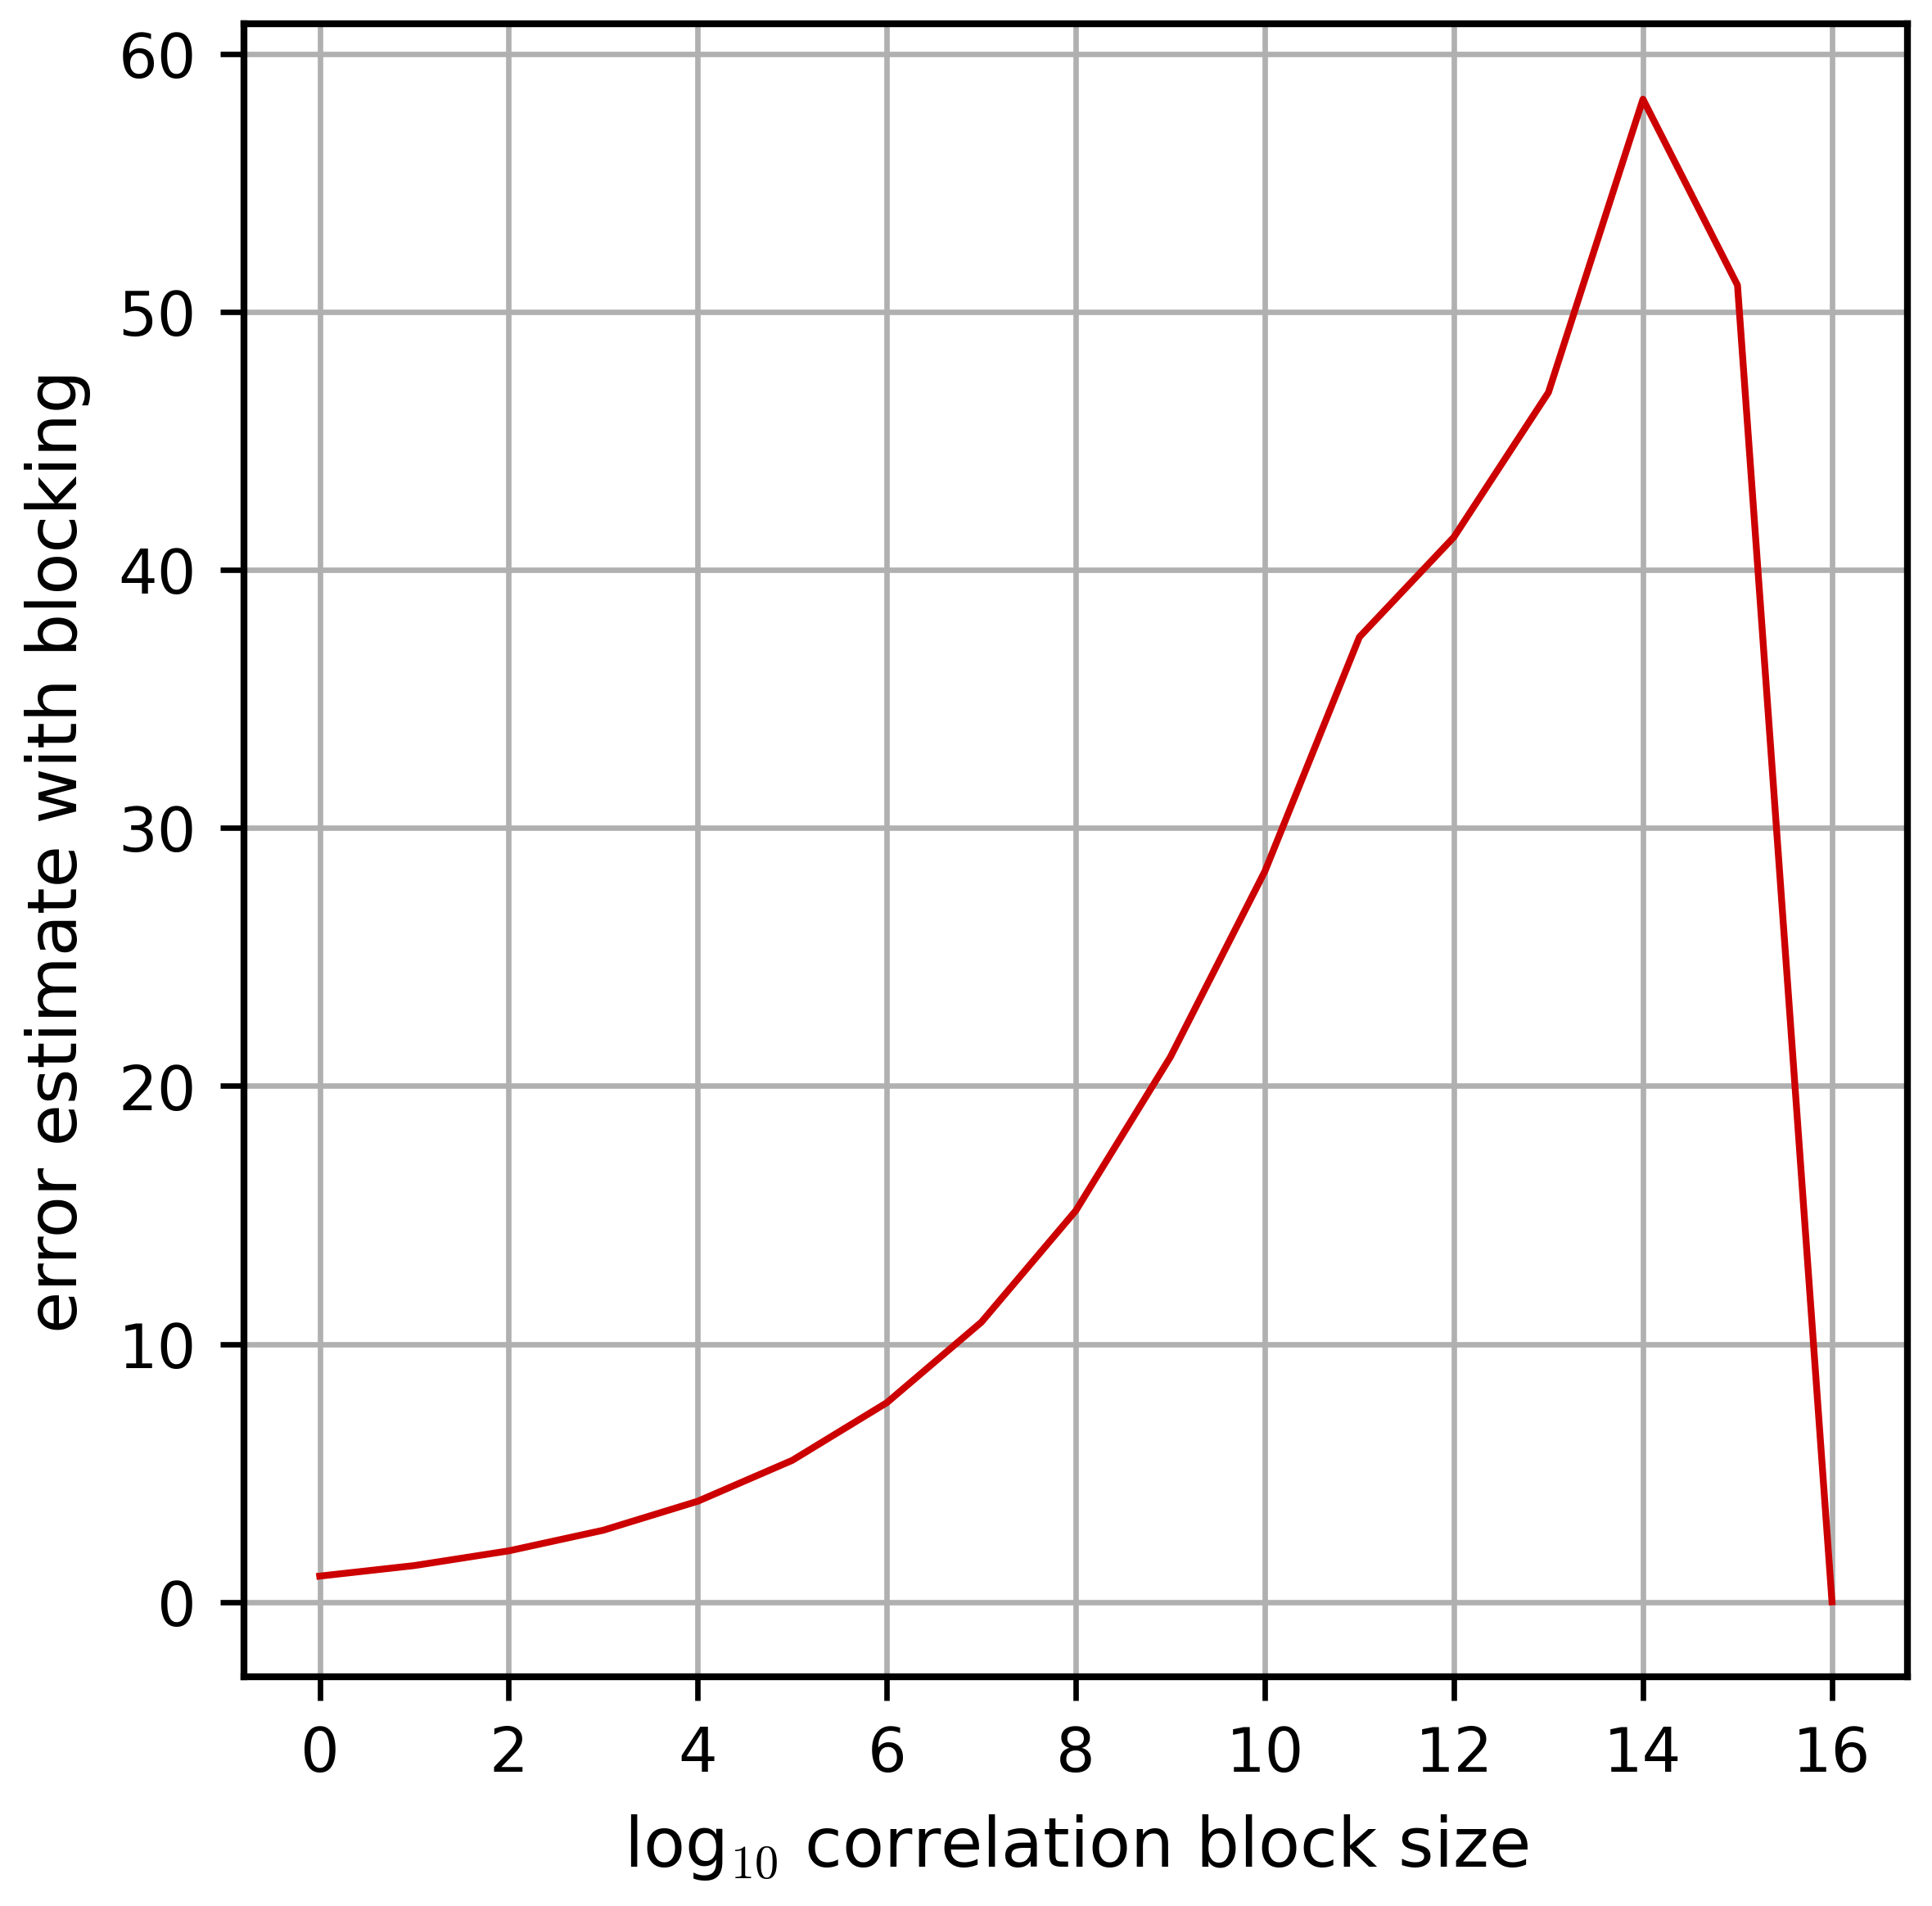

In [13]:
hpa.util.autocorr_bin(states, 17, 1000)


In [22]:
dmu = hpa.msm.dmu_estimate(states, lag=3, n_term=1000)
sigma_dmu = hpa.msm.bootstrap_dmu_estimate(states, lag=3, pow_bin=10, n_resample=30, n_term=1000)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4524.70it/s]


In [23]:
dmu, sigma_dmu

(5.363796180667777, 1.9743981731596882)

In [20]:
dmu_1 = hpa.msm.dmu_estimate(states, lag=2, n_term=1000)
sigma_dmu_1 = hpa.msm.bootstrap_dmu_estimate(states, lag=2, pow_bin=12, n_resample=30, n_term=1000)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4492.95it/s]


In [21]:
dmu_1, sigma_dmu_1

(inf, nan)

Plots

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


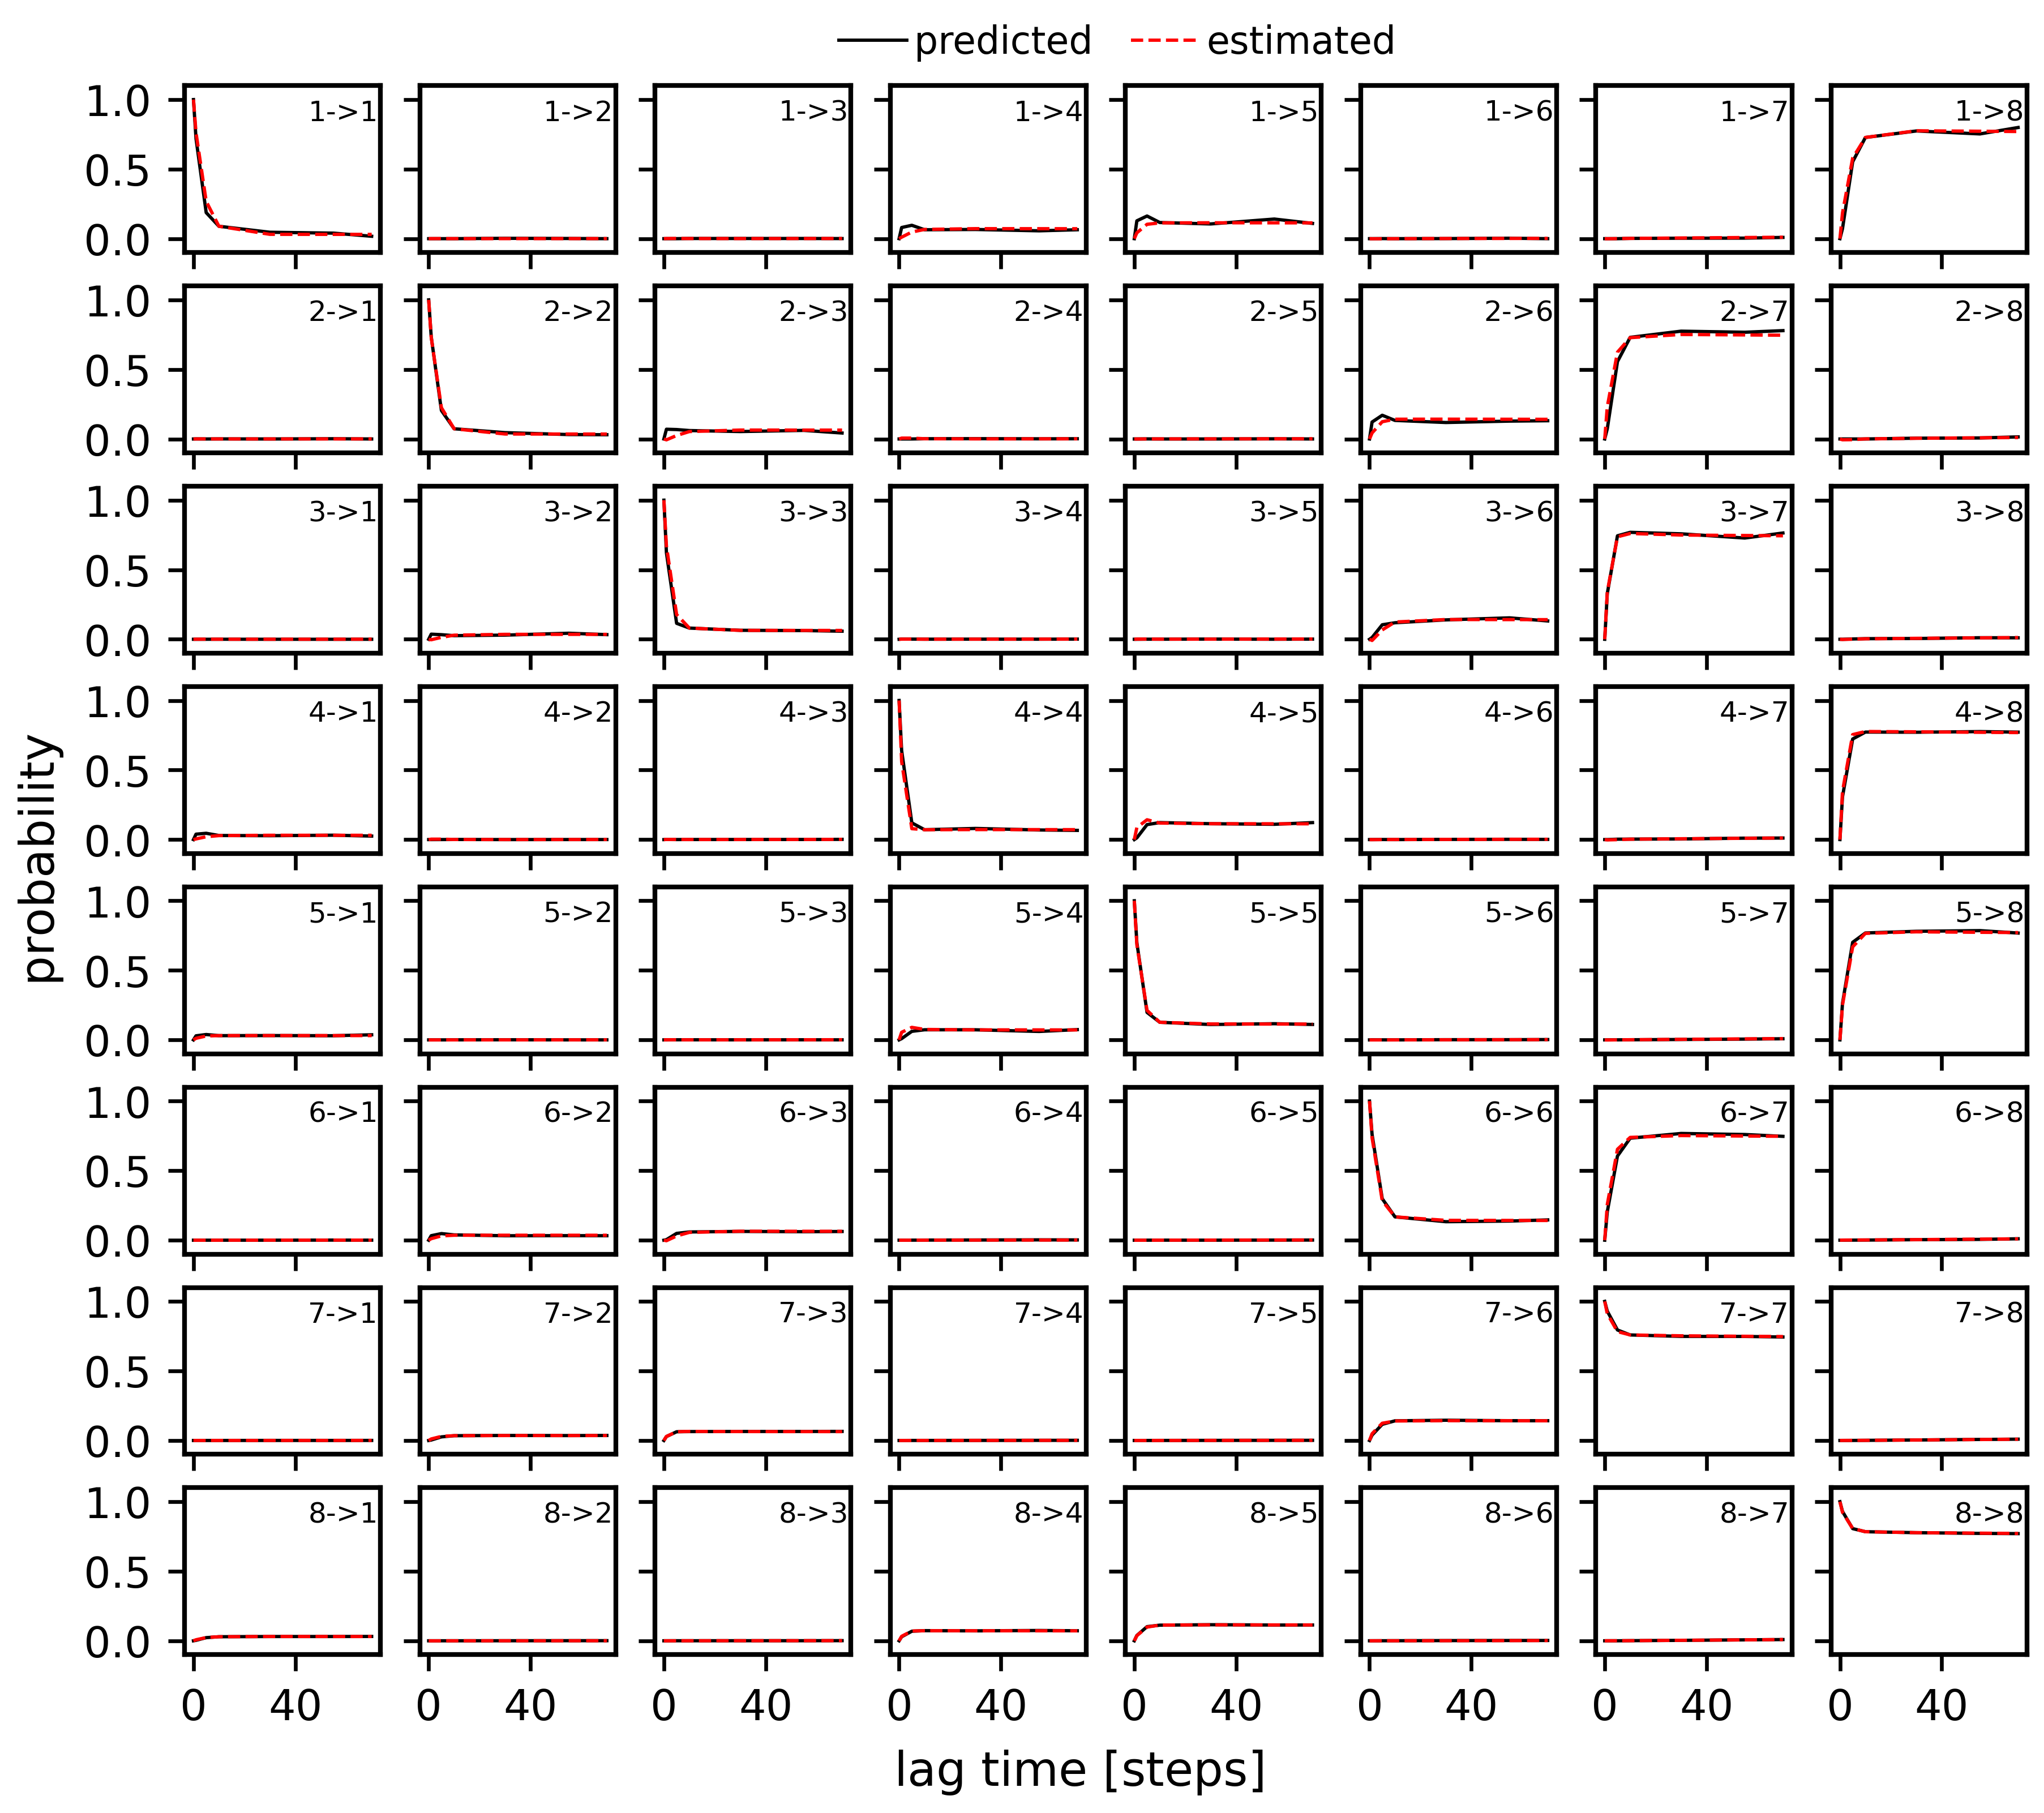

In [43]:
fig, ax = plt.subplots(8,8, figsize=(7,6), sharex=True, sharey=True)
type(ax)
#pred_conf_low = ck8.predictions_samples[0]
#pred_conf_up = ck8.predictions_samples[1]
x = ck8.lagtimes

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,40,80],[0,40,80])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(8):
    for j in range(8):
        ax[i,j].plot(x, ck8.estimates[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(x, ck8.predictions[:,i,j], '--r', linewidth=0.7, label='estimated')
        #ax[i,j].fill_between(x, pred_conf_low[:,i,j], pred_conf_up[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(45,0.85, f'{i+1}->{j+1}', fontsize=6)

        if i==7 and j==3:
            ax[i,j].set_xlabel(r'$\qquad \qquad$ lag time [steps]')
        if i==4 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(3.3,5.9), ncols=2)

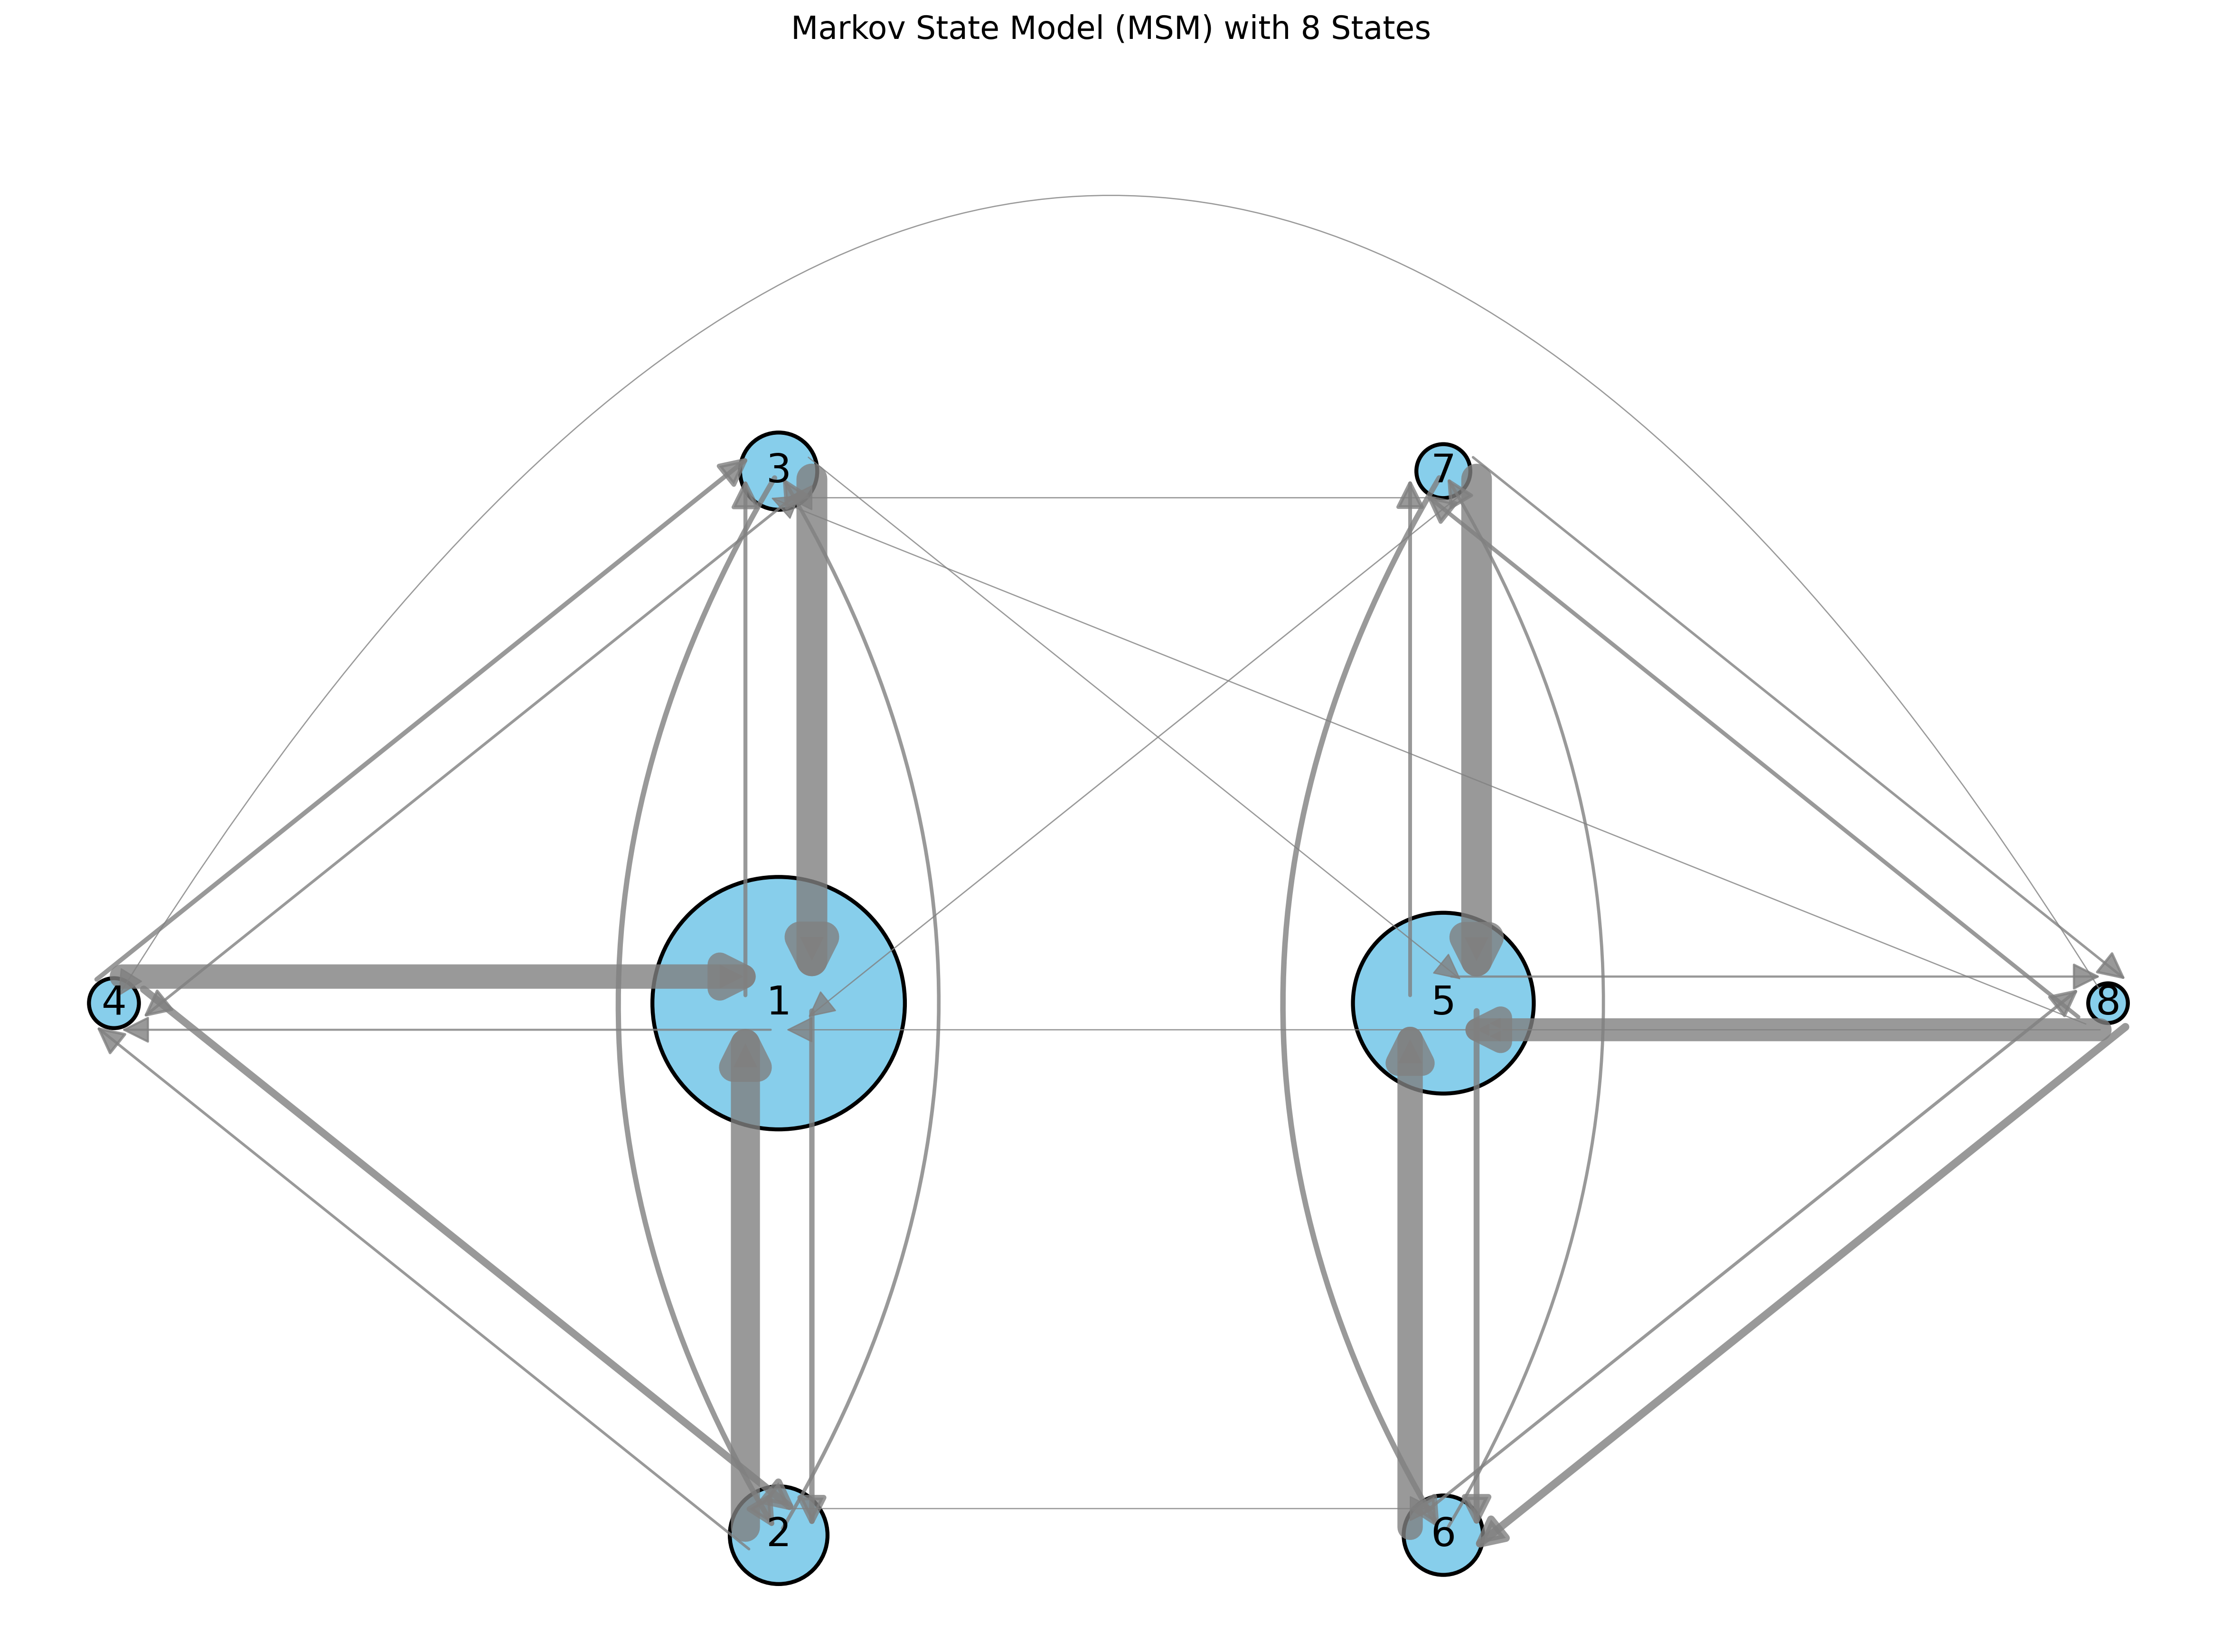

In [210]:
from matplotlib.patches import FancyArrowPatch


# Create a directed graph
G = nx.DiGraph()
st_distr = msm.gather_stats('stationary_distribution').mean

# Add nodes with size proportional to stationary distribution
for i in range(8):
    G.add_node(i, size=st_distr[i])

# Add edges (no self-loops) with weight proportional to transition probabilities
for i in range(8):
    for j in range(8):
        if i != j and tm[i, j] > 1e-4:
            G.add_edge(i, j, weight=tm[i, j])

# Start plot
fig, ax = plt.subplots(figsize=(8, 6))

# Position the nodes using spring layout
positions = np.array([(0,0),(0,-1),(0,1),(-1,0),(1,0),(1,-1),(1,1),(2,0)])/100
pos = dict()
label_dict = dict()
for i in range(8):
    pos[i] = positions[i]
    label_dict[i] = f"{i+1}"

# Draw nodes with size scaled
node_sizes = [8000 * G.nodes[i]['size'] for i in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', edgecolors='k')
nx.draw_networkx_labels(G, pos, labels=label_dict , font_size=10, font_color='black')

# Normalize edge weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights)

# Track already drawn pairs to offset one of the two directions
drawn_pairs = set()

def draw_straight_offset_edge(ax, src, dst, weight, offset_scale=0.0005, color='gray'):
    p1 = np.array(pos[src])
    p2 = np.array(pos[dst])
    vec = p2 - p1
    # Perpendicular unit vector
    perp = np.array([-vec[1], vec[0]])
    perp /= np.linalg.norm(perp)
    
    offset = offset_scale * perp

    # Offset positions
    p1_off = p1 + offset
    p2_off = p2 + offset

    # Draw straight arrow with offset
    arrow = FancyArrowPatch(
        p1_off, p2_off,
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)
    drawn_pairs.add((src, dst))
    
# Draw edges manually with curvature to avoid overlap
def draw_curved_edge(ax, pos, src, dst, weight, color='gray', rad=0.2, special=False):
    if special:
        # Special styling for edge 4 → 7
        rad = 0.5
        color = 'crimson'
    arrow = FancyArrowPatch(
        pos[src], pos[dst],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)

# Draw edges
for u, v in G.edges():
    raw_weight = G[u][v]['weight']
    weight = 0.1 + 2.5 * (raw_weight / max_weight)  # Ensures visibility
    if {u, v} == {3, 7}:  # Edge between 3 and 7 in either direction
        rad = 0.3
        draw_curved_edge(ax, pos, u, v, weight, rad=2.7*rad)
    elif {u, v} == {1, 2} or {u, v} == {5, 6}:
        rad = 0.3 
        draw_curved_edge(ax, pos, u, v, weight, rad=rad)
    else:
        draw_straight_offset_edge(ax, u, v, weight)


# Final plot adjustments
plt.title('Markov State Model (MSM) with 8 States')
plt.axis('off')
plt.tight_layout()
plt.show()


In [211]:
kT=3*0.831446

In [212]:
cycle1234 = tm[0,1]*tm[1,3]*tm[3,2]*tm[2,0]
anticycle1234 = tm[1,0]*tm[3,1]*tm[2,3]*tm[0,2]
dmu1234 = kT*np.log(cycle1234/anticycle1234)
dmu1234

-0.5378386932561983

In [213]:
cycle5678 = tm[4,5]*tm[5,7]*tm[7,6]*tm[6,4]
anticycle5678 = tm[5,4]*tm[7,5]*tm[6,7]*tm[4,6]
dmu5678 = kT*np.log(cycle5678/anticycle5678)
dmu5678

0.7371204329252999

In [214]:
cycle123567 = tm[0,1]*tm[1,5]*tm[5,4]*tm[4,6]*tm[6,2]*tm[2,0]
anticycle123567 = tm[1,0]*tm[5,1]*tm[4,5]*tm[6,4]*tm[2,6]*tm[0,2]
dmu123567 = kT*np.log(cycle123567/anticycle123567)
dmu123567

/tmp/ipykernel_3204451/4072528606.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  dmu123567 = kT*np.log(cycle123567/anticycle123567)


inf

### Compute transition matrix and Delta mu

In [215]:
dG = kT*np.log(tm/tm.T)
dG = np.triu(dG,k=1)
# Create a mask for finite and non-zero values
mask = np.isfinite(dG) & (dG != 0)

# Sum only the valid entries
result = np.sum(dG[mask])
result

/tmp/ipykernel_3204451/2377317243.py:1: RuntimeWarning: divide by zero encountered in divide
  dG = kT*np.log(tm/tm.T)
/tmp/ipykernel_3204451/2377317243.py:1: RuntimeWarning: invalid value encountered in divide
  dG = kT*np.log(tm/tm.T)
/tmp/ipykernel_3204451/2377317243.py:1: RuntimeWarning: divide by zero encountered in log
  dG = kT*np.log(tm/tm.T)


-50.027770117816296